In [11]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data = np.genfromtxt("XRD_scan_data/Al2O3_Mesh 80 (180 to 212 microns)_1.xy", skip_header=1)

angle = data[:,0]
I = data[:,1]

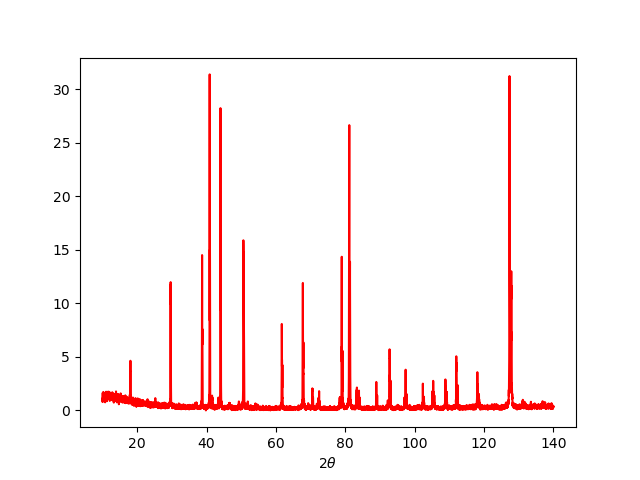

In [12]:
fig,ax = plt.subplots()
ax.plot(angle,I,'r-')
ax.set_xlabel(r'2$\theta$')
plt.show()

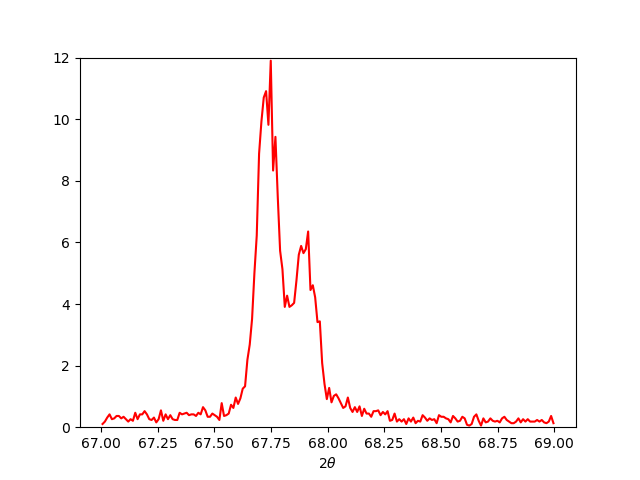

In [21]:
peak_mask = np.logical_and(angle>67, angle<69)
ang_P = angle[peak_mask]
I_P= I[peak_mask]

fig,ax = plt.subplots()
ax.plot(ang_P,I_P,'r-')
ax.set_xlabel(r'2$\theta$')
ax.set_ylim((0,12))
plt.show()

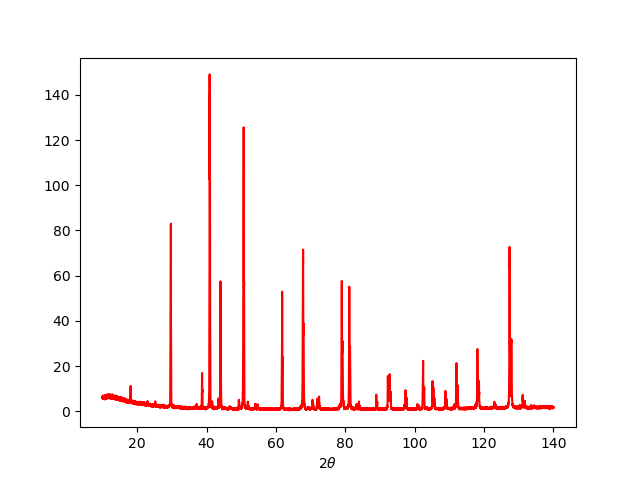

In [28]:
# for each mesh8000
class mesh:
    def __init__(self, angle, intensity, pmin, pmax):
        self.ang = angle
        self.I = intensity
        self.pmin = pmin
        self.pmax = pmax

data = np.genfromtxt("XRD_scan_data/Al2O3_Mesh 80 (180 to 212 microns)_1.xy", skip_header=1)
twoTheta = data[:,0]
I_sum = data[:,1]*0 # initialise as empty because we will sum into it

# MESH 80 (180 to 212 microns)
mesh_80 = mesh(twoTheta,I_sum,180, 212)
for i in range(1,6):
    fname = f"XRD_scan_data/Al2O3_Mesh 80 (180 to 212 microns)_{i}.xy"
    temp = np.genfromtxt(fname, skip_header=1)
    intensity = temp[:,1]
    mesh_80.I = mesh_80.I + intensity
    
fig,ax = plt.subplots()
ax.plot(mesh_80.ang, mesh_80.I,'r-')
ax.set_xlabel(r"$2\theta$")
plt.show()

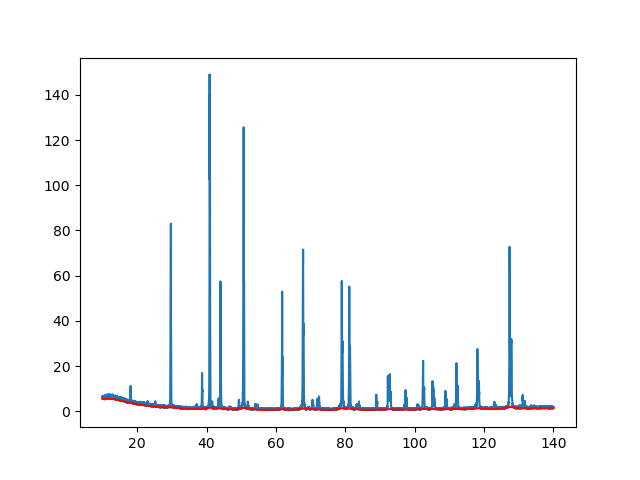

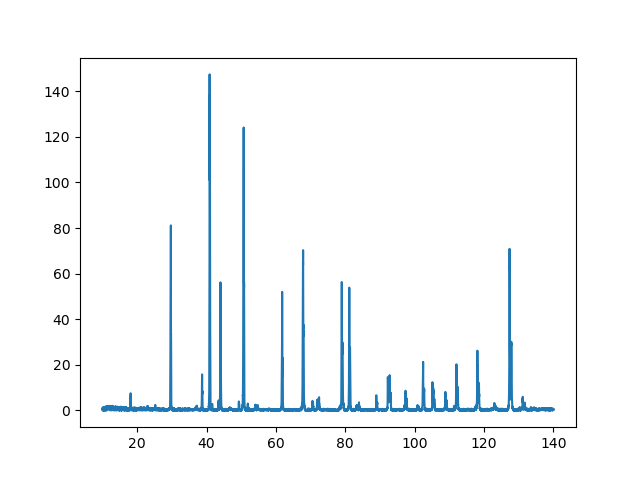

In [52]:
''' Cleaning '''

from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_asls(y, lam=1e5, p=0.01, niter=10):
    """
    Asymmetric least squares baseline (Eilers & Boelens).
    y     : 1D array of intensities
    lam   : smoothness (higher = smoother baseline)
    p     : asymmetry (0<p<1). Smaller p hugs below peaks more strongly.
    niter : reweight iterations
    """
    y = np.asarray(y, float)
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * (D @ D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y <= z)
    return z

def subtract_background_asls(x, y, lam=1e5, p=0.01, niter=10, clip_to_zero=True):
    bkg = baseline_asls(y, lam=lam, p=p, niter=niter)
    y_corr = y - bkg
    if clip_to_zero:
        y_corr = np.maximum(y_corr, 0)
    return bkg, y_corr

mesh_80.bkg, mesh_80.I_clean = subtract_background_asls(mesh_80.ang, mesh_80.I, lam=1e7, p=0.005)

fig,ax = plt.subplots()
ax.plot(mesh_80.ang, mesh_80.I)
ax.plot(mesh_80.ang, mesh_80.bkg, 'r')
plt.show()

fig,ax = plt.subplots()
ax.plot(mesh_80.ang, mesh_80.I_clean)
plt.show()
